# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room Part #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating a simple RAG pipeline with [LangChain v0.1.0](https://blog.langchain.dev/langchain-v0-1-0/)
  

- 🤝 Breakout Room Part #2:
  1. Synthetic Dataset Generation for Evaluation using the [Ragas](https://github.com/explodinggradients/ragas)
  2. Evaluating our pipeline with Ragas
  3. Making Adjustments to our RAG Pipeline
  4. Evaluating our Adjusted pipeline against our baseline
  5. Testing OpenAI's Claim

The only way to get started is to get started - so let's grab our dependencies for the day!

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://blog.langchain.dev/langchain-v0-1-0/) of LangChain v0.1.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [1]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


We'll also get the "star of the show" today, which is Ragas!

In [2]:
!pip install -qU ragas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [3]:
!pip install -qU qdrant-client pymupdf pandas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [4]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.1.0

Building on what we learned last week, we'll be leveraging LangChain v0.1.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.1.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [22]:
!git clone https://github.com/AI-Maker-Space/DataRepository

Cloning into 'DataRepository'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 68 (delta 18), reused 28 (delta 8), pack-reused 8
Receiving objects: 100% (68/68), 69.00 MiB | 35.72 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [6]:
# I used local. 
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader(
   "/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf",
)

documents = loader.load()

In [7]:
documents[0].metadata

{'source': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf',
 'file_path': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf',
 'page': 0,
 'total_pages': 22,
 'format': 'PDF 1.4',
 'title': "A Timeline of Taylor Swift and Kim Kardashian's Feud",
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
 'producer': 'Skia/PDF m123',
 'creationDate': "D:20240424144215+00'00'",
 'modDate': "D:20240424144215+00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 200,
    chunk_overlap = 50
)

documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [9]:
len(documents)

165

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

In [10]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002"
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

In [11]:
from langchain_community.vectorstores import Qdrant

qdrant_vector_store = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="Taylor Swift - Fued - ADA",
)

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about FAISS!

#### Answer #1:
1. It is possible to load the index into memory. It works in RAM so it is limited however it provides fast operation
2. It is a Vecto DB. Vector databases are a type of database designed to store and query high-dimensional vectors efficiently as opposed to OLTP and OLAP.
3. Uses an indexing technique called Hierarchical Navigable Small World (HNSW).
4. The commonly used distance metrics Euclidean Distance, Cosine Similarity, and Dot Product, are fully supported. For this application we will use cosine similarity which is already avalable upon loading.

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [12]:
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [13]:
retrieved_documents = retriever.invoke("Who is Taylor Swift fueding with?")

In [14]:
for doc in retrieved_documents:
  print(doc)

page_content="Kardashian's Feud\nTake a look back at the drama between Taylor Swift and Kim Kardashian\nthrough the years\nBy  \n |  Updated on April 23, 2024 04:46PM EDT\nENTERTAINMENT\nMUSIC\nKelsie Gibson" metadata={'source': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf', 'file_path': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf', 'page': 0, 'total_pages': 22, 'format': 'PDF 1.4', 'title': "A Timeline of Taylor Swift and Kim Kardashian's Feud", 'author': '', 'subject': '', 'keywords': '', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36', 'producer': 'Skia/PDF m123', 'creationDate': "D:20240424144215+00'00'", 'modDate': "D:20240424144215+00'00'", 'trapped': '', '_id': '7a55bfda549d46849d13be16a414e750', '_collection_name': 'Taylor Swift - Fued - ADA'}
page_content='3/22\nMost recently, Swift reflected on the feud yet again

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [40]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

In [203]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [15]:
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context. If you cannot answer the question with the context, please respond with 'I don't know':

Context:
{context}

Question:
{question}
"""

prompt = ChatPromptTemplate.from_template(template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [16]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

####🏗️ Activity #1:

Describe the pipeline shown above in simple terms. You can include a diagram if desired.

#### Answer Activity 1:
Create a question-answering system using GPT-3.5-turbo. The langchain library chains together different operations in a pipeline-like manner using the pipe | operator.

The ChatOpenAI class is used to create an instance of the GPT-3.5-turbo model with temperature set to zero for min creativity. This instance is stored in the primary_qa_llm variable.
The retrieval_augmented_qa_chain is a pipeline of operations that is designed to process a user's question and generate a response. The pipeline is defined using a combination of dictionary mappings and the pipe (|) operator.
The itemgetter function from the operator module is used to extract specific values from a dictionary. Here, it's used to extract the "question" and "context" values from the input.

1. The first step in the pipeline takes a user's question as input. The "context" is populated by getting the value of the "question" key and passing it to the retriever. The "question" is simply the value of the "question" key from the input.
2. The second step uses the RunnablePassthrough.assign method to create a new dictionary where the "context" key is assigned the value of the "context" key from the previous step. This step doesn't call or consider the RunnablePassthrough object in the next step.
3. The third step uses the "context" and "question" values to format a prompt object, which is then passed to the primary_qa_llm to generate a response. The response is stored in a key called "response". The "context" is also populated by getting the value of the "context" key from the previous step.

This pipeline is designed to be invoked with a dictionary that contains a "question" key. The output will be a dictionary that contains a "response" key with the generated answer and a "context" key with the context used to generate the answer as the metadata.

Let's test it out!

In [17]:
question = "Who is Taylor Swift fueding with?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

Kim Kardashian


In [18]:
question = "Why are they fueding?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

I don't know.
[Document(page_content="discussed the longstanding feud between West and Swift in great detail, as\nwell as West's controversial rant during his appearance on Saturday Night", metadata={'source': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf', 'file_path': '/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf', 'page': 7, 'total_pages': 22, 'format': 'PDF 1.4', 'title': "A Timeline of Taylor Swift and Kim Kardashian's Feud", 'author': '', 'subject': '', 'keywords': '', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36', 'producer': 'Skia/PDF m123', 'creationDate': "D:20240424144215+00'00'", 'modDate': "D:20240424144215+00'00'", 'trapped': '', '_id': 'd2c5ef84516b4d67aa143a7631f4f59b', '_collection_name': 'Taylor Swift - Fued - ADA'}), Document(page_content='That Beef!" segment. When asked about if her feud with Swift over 

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

# 🤝 Breakout Room Part #2

## Task 1: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

> NOTE: This process will use `gpt-3.5-turbo-16k` as the base generator and `gpt-4` as the critic - if you're attempting to create a lot of samples please be aware of cost, as well as rate limits.

In [19]:
loader = PyMuPDFLoader(
   "/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/Week 4/Day 1/tswift_fued.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

#### Answer #2:
1. Variety: Different parameters create different splits, this in return will create a more diverse data. This can help the model handle variety of scenarios
2. Avoid Overfitting: If the data is split in the same manner, model may overfit to the way data is split. Afterall splitting impacts retrieval: And therefore generation of the response.
3. Improved Testing & Validation: Using different parameters for splitting allows for more effective testing and validation because it will mimic real-world distribution shifts. It also helps to test specific capabilities of the model. 

In [20]:
len(eval_documents)

53

> NOTE: This cell will take ~5-6min. to generate. If you run into any rate-limit issues - please use GPT-3.5-Turbo as your `critic_llm`. If you see any fields marked `nan` - this is product of rate-limiting issues, and you can safely ignore them for now.

# No matter what I tried with GPT4 I got exceeds rate-limit. For this reason I used GPT3.5. For the same reason I kept my generation to 10 questions. 

In [21]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-3.5-turbo") #<--- If you don't have GPT-4 access, or run into rate-limit, or `nan` issues.
#critic_llm = ChatOpenAI(model="gpt-4-turbo")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

testset = generator.generate_with_langchain_docs(eval_documents, 10, distributions, is_async = False)
testset.to_pandas()

/Users/acrobat/Documents/GitHub/AI-Engineering-Cohort-2/ragas_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filename and doc_id are the same for all nodes.                   
Generating: 100%|██████████| 10/10 [01:25<00:00,  8.51s/it]


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the history of drama between Taylor Sw...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...","Back in 2009, Kim Kardashian spoke with Entert...",simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
1,What was the significance of the snake emoji i...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",The snake emoji was significant in Taylor Swif...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
2,What is the timeline of Taylor Swift and Kim K...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",A Timeline of Taylor Swift and Kim Kardashian'...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
3,What is the timeline of Taylor Swift and Kim K...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",nan,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
4,What song did the person claim to be their fav...,"[carpet, where they asked her what the No. 1 s...",The person claimed that their favorite song as...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
5,How did Taylor Swift describe the impact of th...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",Taylor Swift described the impact of the leake...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
6,What were Kim Kardashian's comments on Taylor ...,"[call in her statements, replied this time, re...","During the Honestly podcast, Kim Kardashian sa...",multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
7,What did Kim Kardashian say about Taylor Swift...,[will be the greatest feeling in the world. Th...,Kim Kardashian claimed that Taylor Swift knew ...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
8,What did Kim Kardashian say about Taylor Swift...,[will be the greatest feeling in the world. Th...,Kim Kardashian claimed that Taylor Swift knew ...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
9,What did Kim Kardashian say about her feud wit...,"[January 14, 2019: Kim Kardashian claims\nther...",Kardashian said during her appearance on Watch...,reasoning,[{'source': '/Users/acrobat/Documents/GitHub/A...,True


# Simple bar chart to see the distribution of simple, multi context and reasoning

In [ ]:
! pip install matplotlib
# I have had numerous tries with GPT4 and GPT3.5. I think the requests are also time based. The more I tried the worse it got. Sometimes it owuld run for 20mins without a result. For this part of the exrcise I opted to use 3.5. 

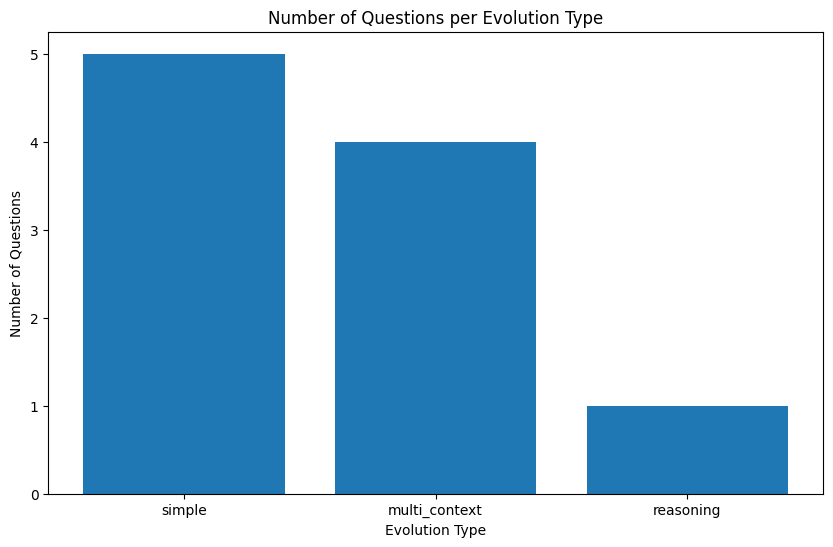

In [24]:
# create a bar chart to analyze the frequency of different question types in the created dataset
import pandas as pd
import matplotlib.pyplot as plt

test_df = testset.to_pandas()
# Assuming 'df' is your DataFrame and it has columns 'question', 'evolution_type'
evolution_counts = test_df['evolution_type'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(evolution_counts.index, evolution_counts.values)
plt.xlabel('Evolution Type')
plt.ylabel('Number of Questions')
plt.title('Number of Questions per Evolution Type')
plt.show()

####❓ Question #3:

`{simple: 0.5, reasoning: 0.25, multi_context: 0.25}`

What exactly does this mapping refer to?

> NOTE: Check out the Ragas documentation on this generation process [here](https://docs.ragas.io/en/stable/concepts/testset_generation.html).

#### Answer#3:
The distribution shows the types of synthetic questions generated:
simple: Simple Q&A
multi_context: questions need a few paragraphs to answer
reasoning: example: 2+2=4. Most taxing therefore I kept this one the minimum.

Let's look at the output and see what we can learn about it!

In [26]:
testset.test_data[1]

DataRow(question="What was the significance of the snake emoji in Taylor Swift and Kim Kardashian's feud?", contexts=["4/24/24, 7:42 AM\nA Timeline of Taylor Swift and Kim Kardashian's Feud\nhttps://people.com/taylor-swift-and-kim-kardashian-feud-timeline-8412119\n11/22\nAlmost a year after Kardashian shared the secretly recorded phone call on\nher Snapchat between her then-husband West and Swift, Swift announced\nthe release of her sixth studio album, Reputation. Swift teased the news\nwith a series of mysterious Instagram videos depicting a serpent. This\nappeared to be her way of reclaiming the snake emoji posted in her\nInstagram comments section (implying that she was a liar)."], ground_truth="The snake emoji was significant in Taylor Swift and Kim Kardashian's feud because it was used to imply that Swift was a liar. Swift reclaimed the snake emoji by using it in her Instagram videos to tease the release of her album Reputation.", evolution_type='simple', metadata=[{'source': '/Us

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [219]:
test_df = testset.to_pandas()

In [27]:
test_df # I did it for 10 questions.

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What is the history of drama between Taylor Sw...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...","Back in 2009, Kim Kardashian spoke with Entert...",simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
1,What was the significance of the snake emoji i...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",The snake emoji was significant in Taylor Swif...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
2,What is the timeline of Taylor Swift and Kim K...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",A Timeline of Taylor Swift and Kim Kardashian'...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
3,What is the timeline of Taylor Swift and Kim K...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",nan,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
4,What song did the person claim to be their fav...,"[carpet, where they asked her what the No. 1 s...",The person claimed that their favorite song as...,simple,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
5,How did Taylor Swift describe the impact of th...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",Taylor Swift described the impact of the leake...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
6,What were Kim Kardashian's comments on Taylor ...,"[call in her statements, replied this time, re...","During the Honestly podcast, Kim Kardashian sa...",multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
7,What did Kim Kardashian say about Taylor Swift...,[will be the greatest feeling in the world. Th...,Kim Kardashian claimed that Taylor Swift knew ...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
8,What did Kim Kardashian say about Taylor Swift...,[will be the greatest feeling in the world. Th...,Kim Kardashian claimed that Taylor Swift knew ...,multi_context,[{'source': '/Users/acrobat/Documents/GitHub/A...,True
9,What did Kim Kardashian say about her feud wit...,"[January 14, 2019: Kim Kardashian claims\nther...",Kardashian said during her appearance on Watch...,reasoning,[{'source': '/Users/acrobat/Documents/GitHub/A...,True


In [28]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [29]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

In [31]:
print(answers)
print("---")
print(contexts)

['The history of drama between Taylor Swift and Kim Kardashian involves ups and downs over the years, including public reconciliations and unreconciliations with Kanye West being a significant part of the narrative in 2015.', "The snake emoji was referenced in Taylor Swift's feud with Kim Kardashian.", "I don't know.", "I don't know.", '"Love Story" by Taylor Swift', 'Taylor Swift described the leaked phone call with Kanye West as proving that she was telling the truth the whole time, indicating that it had a significant impact on her career and emotions.', "I don't know.", 'Kim Kardashian claimed that Taylor Swift knew of the infamous Kanye West "Famous" lyric all along. In response, Taylor Swift referenced the Kanye West and Kim Kardashian drama in her "Look What You Made Me Do" music video.', 'Kim Kardashian claimed that Taylor Swift knew of the infamous Kanye West "Famous" lyric all along. In response, Taylor Swift referenced the Kanye West and Kim Kardashian drama in her "Look Wha

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library. - jay I think it means Hugging face data set alike. Not sure what is a HG dataset mean?

In [32]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [33]:
response_dataset[0]

{'question': 'What is the history of drama between Taylor Swift and Kim Kardashian?',
 'answer': 'The history of drama between Taylor Swift and Kim Kardashian involves ups and downs over the years, including public reconciliations and unreconciliations with Kanye West being a significant part of the narrative in 2015.',
 'contexts': ["Kardashian's Feud\nTake a look back at the drama between Taylor Swift and Kim Kardashian\nthrough the years\nBy  \n |  Updated on April 23, 2024 04:46PM EDT\nENTERTAINMENT\nMUSIC\nKelsie Gibson",
  'about Kardashian.\nAhead, take a look back at Swift and Kardashian’s relationship through the\nyears, including what they’ve said about the drama.\xa0\n2009: Kim Kardashian says she "loves"\nTaylor Swift',
  '2/22\nPHOTO: KEVIN MAZUR/MTV1415/WIREIMAGE\nTaylor Swift and Kim Kardashian have endured many ups and downs\nthrough the years.',
  'through the years.\xa0\nFollowing Swift and Kanye West’s long history, West’s then-wife Kardashian\nbecame part of the nar

In [64]:
# one more
response_dataset[1]

{'question': "What was the significance of the snake emoji in Taylor Swift and Kim Kardashian's feud?",
 'answer': "The snake emoji was referenced in Taylor Swift's feud with Kim Kardashian.",
 'contexts': ['reclaimed the snake emoji posted in her Instagram comments section at the\ntime.\xa0\nAdvertisement\nAdvertisement\nSUBSCRIBE\nSKIP TO CONTENT',
  'me now?" Taylor sings in the new track, also appearing to reference the\nsnake emoji that featured in her feud with the reality TV star.\nApril 23: A source tells PEOPLE Kim',
  "Kardashian's Feud\nTake a look back at the drama between Taylor Swift and Kim Kardashian\nthrough the years\nBy  \n |  Updated on April 23, 2024 04:46PM EDT\nENTERTAINMENT\nMUSIC\nKelsie Gibson",
  '2/22\nPHOTO: KEVIN MAZUR/MTV1415/WIREIMAGE\nTaylor Swift and Kim Kardashian have endured many ups and downs\nthrough the years.'],
 'ground_truth': "The snake emoji was significant in Taylor Swift and Kim Kardashian's feud because it was used to imply that Swift was

## Task 2: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html): This measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

The generated answer is regarded as faithful if all the claims that are made in the answer can be inferred from the given context. 
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html): The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the question, the context and the answer.The Answer Relevancy is defined as the mean cosine similartiy of the original question to a number of artifical questions, which where generated (reverse engineered) based on the answer

- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html): Context Precision is a metric that evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question, ground_truth and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision

Context Relevancy:

- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html): Context recall measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance. To estimate context recall from the ground truth answer, each sentence in the ground truth answer is analyzed to determine whether it can be attributed to the retrieved context or not. In an ideal scenario, all sentences in the ground truth answer should be attributable to the retrieved context.

Context entities recall:

Answer semantic similarity

- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html): The assessment of Answer Correctness involves gauging the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1. A higher score indicates a closer alignment between the generated answer and the ground truth, signifying better correctness. Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score.

Aspect Critique: 

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [34]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [35]:
results = evaluate(response_dataset, metrics)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]No statements were generated from the answer.
No statements were generated from the answer.
Evaluating: 100%|██████████| 50/50 [00:14<00:00,  3.47it/s]


In [36]:
results

{'faithfulness': 1.0000, 'answer_relevancy': 0.4728, 'context_recall': 0.7333, 'context_precision': 0.6806, 'answer_correctness': 0.4994}

In [37]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What is the history of drama between Taylor Sw...,The history of drama between Taylor Swift and ...,[Kardashian's Feud\nTake a look back at the dr...,"Back in 2009, Kim Kardashian spoke with Entert...",1.0,1.000000,0.500000,0.805556,0.822303
1,What was the significance of the snake emoji i...,The snake emoji was referenced in Taylor Swift...,[reclaimed the snake emoji posted in her Insta...,The snake emoji was significant in Taylor Swif...,1.0,0.931908,1.000000,1.000000,0.612027
2,What is the timeline of Taylor Swift and Kim K...,I don't know.,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",A Timeline of Taylor Swift and Kim Kardashian'...,NaN,0.000000,1.000000,0.000000,0.181994
3,What is the timeline of Taylor Swift and Kim K...,I don't know.,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",nan,NaN,0.000000,0.000000,0.000000,0.198202
4,What song did the person claim to be their fav...,"""Love Story"" by Taylor Swift",[giddily replied that it was “Love Story” by S...,The person claimed that their favorite song as...,1.0,0.000000,1.000000,1.000000,0.973924
5,How did Taylor Swift describe the impact of th...,Taylor Swift described the leaked phone call w...,[the leak of her full phone call with Kanye\nW...,Taylor Swift described the impact of the leake...,1.0,0.939053,1.000000,1.000000,0.611770
6,What were Kim Kardashian's comments on Taylor ...,I don't know.,[she likes all of Taylor Swift’s songs\nDuring...,"During the Honestly podcast, Kim Kardashian sa...",NaN,0.000000,0.333333,1.000000,0.181173
7,What did Kim Kardashian say about Taylor Swift...,Kim Kardashian claimed that Taylor Swift knew ...,"[“Famous” lyric all along \n""She totally appro...",Kim Kardashian claimed that Taylor Swift knew ...,1.0,0.928727,1.000000,1.000000,0.614202
8,What did Kim Kardashian say about Taylor Swift...,Kim Kardashian claimed that Taylor Swift knew ...,"[“Famous” lyric all along \n""She totally appro...",Kim Kardashian claimed that Taylor Swift knew ...,1.0,0.928671,1.000000,1.000000,0.614202
9,What did Kim Kardashian say about her feud wit...,I don't know.,[Kardashian's Feud\nTake a look back at the dr...,Kardashian said during her appearance on Watch...,NaN,0.000000,0.500000,0.000000,0.183880


## Task 3: Making Adjustments to our RAG Pipeline

Now that we have established a baseline - we can see how any changes impact our pipeline's performance!

Let's modify our retriever and see how that impacts our Ragas metrics!

> NOTE: MultiQueryRetriever is expanded on [here](https://python.langchain.com/docs/modules/data_connection/retrievers/MultiQueryRetriever) but for now, the implementation is not important to our lesson!

In [38]:
from langchain.retrievers import MultiQueryRetriever

advanced_retriever = MultiQueryRetriever.from_llm(retriever=retriever, llm=primary_qa_llm)

We'll also re-create our RAG pipeline using the abstractions that come packaged with LangChain v0.1.0!

First, let's create a chain to "stuff" our documents into our context!

In [41]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

Next, we'll create the retrieval chain!

In [42]:
from langchain.chains import create_retrieval_chain

retrieval_chain = create_retrieval_chain(advanced_retriever, document_chain)

In [43]:
response = retrieval_chain.invoke({"input": "Who is Taylor Swift fueding with?"})

In [44]:
print(response["answer"])

Taylor Swift is feuding with Kim Kardashian.


In [45]:
response = retrieval_chain.invoke({"input": "Why are they fueding?"})

In [46]:
print(response["answer"])

Taylor Swift and Kim Kardashian have been feuding primarily due to their involvement in the longstanding feud between Taylor Swift and Kanye West. The feud escalated in 2016 when Kanye West released a song called "Famous" which made jabs at Taylor Swift, and Kim Kardashian became involved in the drama by publicly sharing recordings of phone calls between Swift and West. This led to a significant amount of tension and back-and-forth between the parties involved.


Well, just from those responses this chain *feels* better - but lets see how it performs on our eval!

Let's do the same process we did before to collect our pipeline's contexts and answers.

In [47]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

Now we can convert this into a dataset, just like we did before.

In [48]:
response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's evaluate on the same metrics we did for the first pipeline and see how it does!

In [49]:
advanced_retrieval_results = evaluate(response_dataset_advanced_retrieval, metrics)

Evaluating: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


In [50]:
advanced_retrieval_results_df = advanced_retrieval_results.to_pandas()
advanced_retrieval_results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What is the history of drama between Taylor Sw...,The drama between Taylor Swift and Kim Kardash...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...","Back in 2009, Kim Kardashian spoke with Entert...",1.00,0.956924,0.500000,0.937925,0.823451
1,What was the significance of the snake emoji i...,The snake emoji was significant in Taylor Swif...,[Kardashian's Feud\nTake a look back at the dr...,The snake emoji was significant in Taylor Swif...,1.00,0.999993,0.000000,1.000000,0.491492
2,What is the timeline of Taylor Swift and Kim K...,The timeline of Taylor Swift and Kim Kardashia...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",A Timeline of Taylor Swift and Kim Kardashian'...,1.00,0.929285,1.000000,0.200000,0.232946
3,What is the timeline of Taylor Swift and Kim K...,The timeline of Taylor Swift and Kim Kardashia...,"[4/24/24, 7:42 AM\nA Timeline of Taylor Swift ...",nan,0.75,0.000000,0.000000,0.000000,0.176872
4,What song did the person claim to be their fav...,The person claimed that their favorite song wa...,"[When asked what her favorite Swift album was,...",The person claimed that their favorite song as...,1.00,0.926416,1.000000,1.000000,0.742768
5,How did Taylor Swift describe the impact of th...,Taylor Swift described the leaked phone call w...,[the leak of her full phone call with Kanye\nW...,Taylor Swift described the impact of the leake...,1.00,0.939072,1.000000,1.000000,0.671791
6,What were Kim Kardashian's comments on Taylor ...,Kim Kardashian mentioned on the Honestly podca...,[she likes all of Taylor Swift’s songs\nDuring...,"During the Honestly podcast, Kim Kardashian sa...",1.00,0.000000,0.333333,0.866667,0.485762
7,What did Kim Kardashian say about Taylor Swift...,Kim Kardashian claimed that Taylor Swift knew ...,"[“Famous” lyric all along \n""She totally appro...",Kim Kardashian claimed that Taylor Swift knew ...,1.00,0.922434,1.000000,1.000000,0.739620
8,What did Kim Kardashian say about Taylor Swift...,Kim Kardashian claimed that Taylor Swift knew ...,"[“Famous” lyric all along \n""She totally appro...",Kim Kardashian claimed that Taylor Swift knew ...,1.00,0.928650,1.000000,1.000000,0.740578
9,What did Kim Kardashian say about her feud wit...,"On Watch What Happens Live, Kim Kardashian cla...","[about Kardashian.\nAhead, take a look back at...",Kardashian said during her appearance on Watch...,1.00,0.904859,0.500000,0.166667,0.714982


## Task 4: Evaluating our Adjusted Pipeline Against Our Baseline

Now we can compare our results and see what directional changes occured!

Let's refresh with our initial metrics.

In [51]:
results

{'faithfulness': 1.0000, 'answer_relevancy': 0.4728, 'context_recall': 0.7333, 'context_precision': 0.6806, 'answer_correctness': 0.4994}

And see how our advanced retrieval modified our chain!

In [52]:
advanced_retrieval_results

{'faithfulness': 0.9750, 'answer_relevancy': 0.7508, 'context_recall': 0.6333, 'context_precision': 0.7171, 'answer_correctness': 0.5820}

In [53]:
import pandas as pd

df_original = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_comparison = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'MultiQueryRetriever with Document Stuffing'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')

df_merged['Delta'] = df_merged['MultiQueryRetriever with Document Stuffing'] - df_merged['Baseline']

df_merged

,Metric,Baseline,MultiQueryRetriever with Document Stuffing,Delta
0,faithfulness,1.000000,0.975000,-0.025000
1,answer_relevancy,0.472836,0.750763,0.277927
2,context_recall,0.733333,0.633333,-0.100000
3,context_precision,0.680556,0.717126,0.036570
4,answer_correctness,0.499368,0.582026,0.082658


## Task 5: Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #2:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

#### Answer to Activity #2:

In [54]:
# Create an instance of the OpenAIEmbeddings class called new_embeddings. This is used to generate embeddings for text data using OpenAI's models.
new_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [55]:
# This is an instace of Qrant class using from_documents method. This is used to create a vector store for the documents and embeddings.
vector_store = qdrant = Qdrant.from_documents(
    documents,  # This is a list of Document objects.
    new_embeddings,
    location=":memory:",  # where data is stored. memory means it is stored in RAM.
    collection_name="Taylor Swift - Fued - MQR",  #name of the collection that Qrand instance will manage
)

In [56]:
#as_retriever method is called on vector_store to create a retriever object called new_retriever.
new_retriever = vector_store.as_retriever()

In [57]:
# MultiQueryRetriever class is called with from_llm method to create a new retriever object called new_advanced_retriever. primary_qa_llm is passed as an argument to the method.
# MultiQueryRetriever is used to create a retriever that can handle multiple queries at once.
new_advanced_retriever = MultiQueryRetriever.from_llm(retriever=new_retriever, llm=primary_qa_llm)

In [58]:
# create_retrieval_chain is a sequence of operations that are used to create a retrieval chain.
new_retrieval_chain = create_retrieval_chain(new_advanced_retriever, document_chain)

In [59]:
# test_questions is a list of questions that are used to test the retrieval chain.
answers = []
contexts = []

for question in test_questions:
  response = new_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

In [60]:
# Dataset is HG face datasets library that is used to create a dataset from the given dictionary.
# from_dict method is used to create a dataset from the dictionary in memory
new_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

In [61]:
new_advanced_retrieval_results = evaluate(new_response_dataset_advanced_retrieval, metrics)

Evaluating: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


In [62]:
new_advanced_retrieval_results

{'faithfulness': 0.7383, 'answer_relevancy': 0.8550, 'context_recall': 0.8667, 'context_precision': 0.7067, 'answer_correctness': 0.5776}

In [63]:
# build a dataframe to compare the results of the different retrieval methods
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'Baseline'])
df_original = pd.DataFrame(list(advanced_retrieval_results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(new_advanced_retrieval_results.items()), columns=['Metric', 'Text Embedding 3'])

df_merged = pd.merge(df_original, df_comparison, on='Metric')
df_merged = pd.merge(df_baseline, df_merged, on="Metric")

df_merged['Delta - TE3 -> ADA'] = df_merged['Text Embedding 3'] - df_merged['ADA']
df_merged['Delta - TE3 -> Baseline'] = df_merged['Text Embedding 3'] - df_merged['Baseline']

df_merged

,Metric,Baseline,ADA,Text Embedding 3,Delta - TE3 -> ADA,Delta - TE3 -> Baseline
0,faithfulness,1.000000,0.975000,0.738333,-0.236667,-0.261667
1,answer_relevancy,0.472836,0.750763,0.854988,0.104225,0.382152
2,context_recall,0.733333,0.633333,0.866667,0.233333,0.133333
3,context_precision,0.680556,0.717126,0.706746,-0.010380,0.026190
4,answer_correctness,0.499368,0.582026,0.577645,-0.004381,0.078277


####❓ Question #4:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

#### Answer #4:
In my opinion, it is better but not significantly. The difference between context_precision and answer_correctness are miniscule so I consider them equal.
answer_relevancy and context_recall are much ebtter for the text embedding  small model. 
Faithfulness, imo is low because I used GPT3.5 for both runs. 
 

## BONUS ACTIVITY: Showcase Multi-Context Perfomance Changes

Now that we've looked at a number of different examples - showcase the difference on the multi-context *specific* questions that were synthetically generated.

> NOTE: You have all the data you'll need already in the notebook if you made it to this step!

In [253]:
### YOUR CODE HERE